### Imports

In [51]:
from fastai.imports import *
from fastai.structured import train_cats
import numpy as np
import pandas as pd
#df = pd.read_csv('data/transform_hot_full.csv', index_col=0)
df = pd.read_csv('data/test_raw_df.csv', index_col=0)
#df = pd.read_csv('data/transform_hot_mini.csv', index_col=0)

### Helper functions

In [52]:
m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
map_names = [n for x, n, in m_names.items()]
map_names_swapped = dict([(value, key) for key, value in m_names.items()])

h_names= pd.read_csv("exports/hero_name_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
hero_names = [n for x, n, in h_names.items()]

In [53]:
mns = [x[1] for x in list(enumerate(map_names))]
yhns = ['yours_'+x[1] for x in list(enumerate(hero_names))]
thns = ['theirs_'+x[1] for x in list(enumerate(hero_names))]
#col_names = mns+yhns+thns
col_names = df.loc[:, df.columns != 'outcome'].columns
col_names

Index(['game_map', 'game_type', 'winnerA', 'winnerB', 'winnerC', 'winnerD',
       'winnerE', 'loserA', 'loserB', 'loserC', 'loserD', 'loserE'],
      dtype='object')

In [54]:
tmp = df[-1:].transpose()
tmp.columns = ["data"]
print(tmp[tmp['data']==True])

Empty DataFrame
Columns: [data]
Index: []


### Training

#### Prepare X and Y for train and val sets.

In [55]:
#SAMPLE_SIZE = 3000
data1 = df#.sample(n = SAMPLE_SIZE, random_state = 1, axis = 0)
train_cats(data1)

## Training many models for comparison

In [56]:
#from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
from sklearn import linear_model, ensemble, gaussian_process, naive_bayes, neighbors, svm, tree, discriminant_analysis
from sklearn import model_selection
from xgboost import XGBClassifier

In [57]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(), #slow
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True), #slow
    #svm.NuSVC(probability=True), #slow
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [58]:
Target = ['outcome']
data1[Target].mean()

outcome    0.501767
dtype: float64

In [59]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
p_bar = tqdm(MLA)
row_index = 0
for alg in p_bar:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    p_bar.set_description(f'Working on "{MLA_name}"')
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[col_names], data1[Target], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[col_names], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[col_names])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Working on "XGBClassifier": 100%|██████████| 19/19 [01:54<00:00,  6.04s/it]                


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.605161,0.520389,0.0178071,0.85595
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.544856,0.519022,0.0119385,0.594676
18,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.890239,0.514311,0.0181731,0.421138
7,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.516394,0.509689,0.0087595,0.0301797
16,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.516406,0.509611,0.00870536,0.0552523
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.516511,0.509367,0.00814323,0.317361
17,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.529694,0.509233,0.0109539,0.0121172
11,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.516133,0.508256,0.011681,0.00733292
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.985389,0.505411,0.00542638,0.975806
15,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.503144,0.0145999,0.0216884


Text(0, 0.5, 'Algorithm')

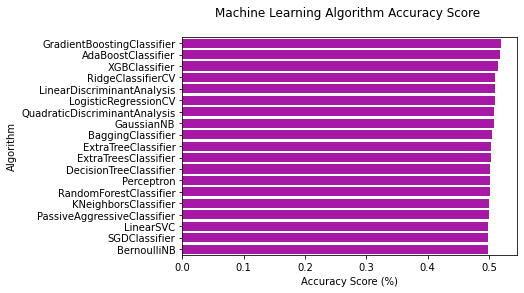

In [60]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')